<a href="https://colab.research.google.com/github/ucalyptus/Earthquake_/blob/master/Earthquake_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install numpy==1.15.0
!pip install catboost

In [0]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
import matplotlib.pyplot as plt

In [5]:
##IMPORT DATASET FROM KAGGLE
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [6]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2628            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9918            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4139            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2289           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [7]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 13.1MB/s]
 99% 240M/242M [00:01<00:00, 168MB/s]
100% 242M/242M [00:01<00:00, 156MB/s]
 99% 2.01G/2.03G [00:14<00:00, 171MB/s]
100% 2.03G/2.03G [00:14<00:00, 151MB/s]


In [8]:
!ls 

sample_data  sample_submission.csv  test.zip  train.csv.zip


In [12]:
!unzip train.csv.zip


Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [13]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
train = pd.read_csv('train.csv',nrows = 6000000, dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})

In [17]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [0]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]




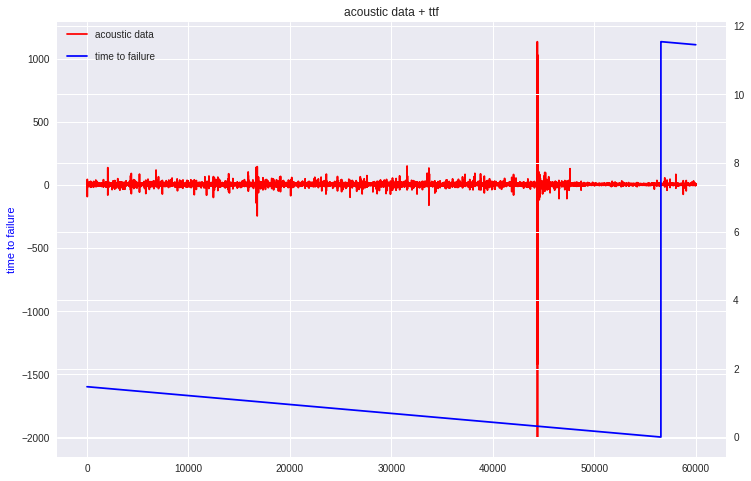

In [22]:
fig, ax1 = plt.subplots(figsize=(12,8))
plt.title("acoustic data + ttf")
plt.plot(train_ad_sample_df,color='r')
ax1.set_ylabel('acoustic data',color='r')
plt.legend(['acoustic data'],loc=(0.01,0.95))
ax2 = ax1.twinx()
plt.plot(train_ttf_sample_df,color='b')
ax1.set_ylabel('time to failure',color='b')
plt.legend(['time to failure'],loc=(0.01,0.9))
plt.grid(True)




In [0]:
#This is a supervised learning , we need to find co relation betwwen ad and ttf, btw there are only two features.. ideally we need more features

In [0]:
def generatefeatures(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  return pd.Series(strain)

In [0]:
##kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
##Data sets with high kurtosis tend to have heavy tails,or outliers.Data sets with low kurtosis tend to have light tails , or lack of outliers.


##Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive or negative,or undefined.
##positive skewness is going to right, left negative and so on.


##quantiles are cut points dividing the range of a probdist into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way.

In [0]:
train = pd.read_csv('train.csv',iterator=True,chunksize=150_000, dtype={'acoustic_data':np.int16,'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = generatefeatures(df['acoustic_data'])
  X_train = X_train.append(ch,ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [26]:
X_train.describe()

,0,1,2,3,4,5,6
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000


In [27]:
X_train.head(10)

,0,1,2,3,4,5,6
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0
5,4.913513,5.434111,-144.0,142.0,50.215147,-0.100697,-10.0
6,4.855660,5.687823,-78.0,120.0,23.173004,0.208810,-12.0
7,4.505427,5.854512,-134.0,139.0,52.388738,-0.176333,-11.0
8,4.717833,7.789643,-156.0,168.0,65.360261,-0.160166,-16.0
9,4.730960,6.890459,-126.0,152.0,53.760207,0.150779,-14.0


In [28]:
#Catboost explained simply:

"""
1. We first model data with simple models and analyze data for errors.
2. These errors signify data points that are difficult to fit by a simple model
3. Then for later models, we particularly focus on those hard to fit data to get them right.
4. In the end, we combine all the predictors by giving some weights to each predictor.





"""

'\n1. We first model data with simple models and analyze data for errors.\n2. These errors signify data points that are difficult to fit by a simple model\n3. Then for later models, we particularly focus on those hard to fit data to get them right.\n4. In the end, we combine all the predictors by giving some weights to each predictor.\n\n\n\n\n\n'

In [30]:
train_pool = Pool(X_train,y_train)
m = CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent=True)
m.best_score_


{'learn': {'MAE': 1.856830702463856}}

In [0]:
##we will use SVM for regression
##kernel will be gaussian aka radial basis
##k(x1,x2) = exp(-gamma*(x1-x2)^2)

In [0]:
###using GridSearch for hype-optimization

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001,0.005,0.01,0.02,0.05,0.1],
              'C':[0.1,0.2,0.25,0.5,1,1.5,2]}]

reg1 = GridSearchCV(SVR(kernel='rbf',tol=0.01),parameters,cv=5)
reg1.fit(X_train_scaled,y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV Score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)



Best CV Score: 0.3662
{'C': 2, 'gamma': 0.1}
